# Imports

In [1]:
from IPython.display import display

from itertools import permutations

import json

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

from scipy import stats

import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

# Dados

## Analisando json

In [2]:
with open(os.path.join('..', 'datasets', 'receitas.json')) as f:
    raw_data = json.loads(f.read())

In [3]:
def show_dataset_format(dataset):
    def show(data, i):
        for k, v in data.items():
            tabs = '\t' * i
            v_type = type(v).__name__

            if isinstance(v, dict):
                print(tabs + f'{k}: ({v_type})')
                show(v, i + 1)
            elif isinstance(v, list):
                list_type = type(v[0]).__name__ if len(v) > 0 else ''
                shape = np.array(v).shape
                print(tabs + f'{k}: ({v_type} [{list_type}]) {shape}')
            else:
                print(tabs + f'{k}: ({v_type})')

    show(dataset[0], 0)

print('Dataset length:', len(raw_data), '\n')
show_dataset_format(raw_data)

Dataset length: 20130 

directions: (list [str]) (3,)
fat: (float)
date: (str)
categories: (list [str]) (11,)
calories: (float)
desc: (NoneType)
protein: (float)
rating: (float)
title: (str)
ingredients: (list [str]) (15,)
sodium: (float)


## Carregando pandas dataframe

In [4]:
data = pd.read_json(os.path.join('..', 'datasets', 'receitas.json'))
data = data.sort_values('date')
data = data.reset_index().drop('index', axis=1)
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,[Blanch onions in a saucepan of boiling water ...,18.0,1996-09-01 20:47:00+00:00,"[Bon Appétit, Salad, Mushroom, Watercress, Fet...",216.0,"The technique for cooking vegetables in water,...",6.0,0.000,Portobello Mushroom Salad à la Grecque,"[12 pearl onions, 6 tablespoons olive oil, 2 t...",812.0
1,[1. Soak the mushrooms in enough hot water to ...,5.0,1998-09-17 19:09:30+00:00,"[Soup/Stew, Mushroom, Vegetarian, Sukkot, Rosh...",234.0,When I first heard about Ari Weinzweig's delic...,14.0,4.375,Zingerman's Ann Arbor Mushroom and Barley Soup,"[2 tablespoons dried porcini mushrooms, 2 tabl...",1468.0
2,"[Preheat an oven to 350ºF., Cut the lemon into...",102.0,1998-09-22 13:11:01+00:00,"[Chicken, Ginger, Rice, Appetizer, Roast, Saut...",1428.0,"(Pollo Arrosto All'Arancia, Limone, e Zenzero)",98.0,3.750,"Roast Chicken with Orange, Lemon, and Ginger","[1 lemon, 1 roasting chicken, about 5 pounds, ...",1089.0
3,[Warm 2 tablespoons of the olive oil in a saut...,32.0,1998-09-22 13:11:02+00:00,"[Braise, Stew, Rosh Hashanah/Yom Kippur, Dinne...",694.0,(Stufadin di Zuca Zala),59.0,4.375,Braised Meat with Butternut Squash,"[4 tablespoons olive oil, 2 large onions, chop...",824.0
4,[Rinse the spinach well and remove the stems. ...,10.0,1999-01-13 04:00:00+00:00,"[Side, Sauté, Vegetarian, Rosh Hashanah/Yom Ki...",159.0,(Spinaci con Pinoli e Passerine),7.0,4.375,Spinach with Pine Nuts and Raisins,"[2 1/2 pounds spinach, 2 to 3 tablespoons oliv...",539.0


In [5]:
def describe(df):
    print(f'Length: {len(df)}')

    print('\nNulls')
    print(df.isna().sum())

    print('\nDescription')
    print(df.describe())
    
    print('\nInfo')
    print(data.info())

describe(data)

Length: 20130

Nulls
directions       19
fat            4222
date             19
categories       19
calories       4154
desc           6635
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

Description
                fat      calories        protein        rating        sodium
count  1.590800e+04  1.597600e+04   15929.000000  20100.000000  1.597400e+04
mean   3.460975e+02  6.307857e+03      99.946199      3.713060  6.211474e+03
std    2.043102e+04  3.585851e+05    3835.616663      1.343144  3.328903e+05
min    0.000000e+00  0.000000e+00       0.000000      0.000000  0.000000e+00
25%    7.000000e+00  1.980000e+02       3.000000      3.750000  8.000000e+01
50%    1.700000e+01  3.310000e+02       8.000000      4.375000  2.940000e+02
75%    3.300000e+01  5.860000e+02      27.000000      4.375000  7.110000e+02
max    1.722763e+06  3.011122e+07  236489.000000      5.000000  2.767511e+07

Info
<class 'pandas.core.frame.DataFram

## Removendo nulos

In [6]:
rm_nulls_cols = [
    'directions', 'date', 'categories', 'title', 'ingredients',
    'fat', 'calories', 'protein', 'rating', 'sodium', 'desc'
]
data = data.dropna(subset = rm_nulls_cols)
describe(data)

Length: 10608

Nulls
directions     0
fat            0
date           0
categories     0
calories       0
desc           0
protein        0
rating         0
title          0
ingredients    0
sodium         0
dtype: int64

Description
                fat      calories        protein        rating        sodium
count  1.060800e+04  1.060800e+04   10608.000000  10608.000000  1.060800e+04
mean   4.006124e+02  7.403782e+03     121.733503      3.804558  7.275736e+03
std    2.380737e+04  4.188648e+05    4553.387738      1.263118  3.886472e+05
min    0.000000e+00  0.000000e+00       0.000000      0.000000  0.000000e+00
25%    9.000000e+00  2.060000e+02       3.000000      3.750000  1.000000e+02
50%    1.900000e+01  3.510000e+02       9.000000      4.375000  3.270000e+02
75%    3.500000e+01  6.120000e+02      29.000000      4.375000  7.652500e+02
max    1.722763e+06  3.011122e+07  236489.000000      5.000000  2.767511e+07

Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10608 entries, 0 

## Removendo outliers

In [7]:
rm_outlier_cols = ['fat', 'calories', 'protein', 'sodium']

for col in rm_outlier_cols:
    data = data[(np.abs(stats.zscore(data[col])) < 2)]

## Mostrando grafico dos dados normalizados

In [8]:
def normalize(df, cols):
    ret_df = df.copy()
    scaler = MinMaxScaler()
    ret_df[cols] = scaler.fit_transform(df[cols])

    return ret_df

normalize_cols = ['fat', 'calories', 'protein', 'sodium']
normalized_data = normalize(data, normalize_cols)
normalized_data.head(4)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,[Blanch onions in a saucepan of boiling water ...,0.033645,1996-09-01 20:47:00+00:00,"[Bon Appétit, Salad, Mushroom, Watercress, Fet...",0.025046,"The technique for cooking vegetables in water,...",0.045802,0.000,Portobello Mushroom Salad à la Grecque,"[12 pearl onions, 6 tablespoons olive oil, 2 t...",0.127493
1,[1. Soak the mushrooms in enough hot water to ...,0.009346,1998-09-17 19:09:30+00:00,"[Soup/Stew, Mushroom, Vegetarian, Sukkot, Rosh...",0.027134,When I first heard about Ari Weinzweig's delic...,0.106870,4.375,Zingerman's Ann Arbor Mushroom and Barley Soup,"[2 tablespoons dried porcini mushrooms, 2 tabl...",0.230491
2,"[Preheat an oven to 350ºF., Cut the lemon into...",0.190654,1998-09-22 13:11:01+00:00,"[Chicken, Ginger, Rice, Appetizer, Roast, Saut...",0.165584,"(Pollo Arrosto All'Arancia, Limone, e Zenzero)",0.748092,3.750,"Roast Chicken with Orange, Lemon, and Ginger","[1 lemon, 1 roasting chicken, about 5 pounds, ...",0.170984
3,[Warm 2 tablespoons of the olive oil in a saut...,0.059813,1998-09-22 13:11:02+00:00,"[Braise, Stew, Rosh Hashanah/Yom Kippur, Dinne...",0.080473,(Stufadin di Zuca Zala),0.450382,4.375,Braised Meat with Butternut Squash,"[4 tablespoons olive oil, 2 large onions, chop...",0.129377


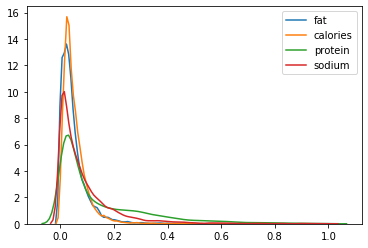

In [9]:
# Distribuição dos valores após a transformação
fig, axis = plt.subplots()

sns.kdeplot(normalized_data['fat'], ax=axis)
sns.kdeplot(normalized_data['calories'], ax=axis)
sns.kdeplot(normalized_data['protein'], ax=axis)
sns.kdeplot(normalized_data['sodium'], ax=axis)

## Analisando variaveis x rating

mean: 3.799814027630181
median: 4.375


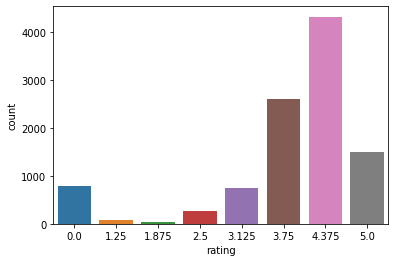

In [10]:
# sns.factorplot("rating", data=data, aspect=2, kind="count", color='steelblue')
sns.countplot(data=data, x="rating")
print('mean:', data.rating.mean())
print('median:', data.rating.median())

### Insight
A maioria das receitas costumam ter notas entre 3.75 e 4. Poucas receitas tem nota entre 0 e 3.

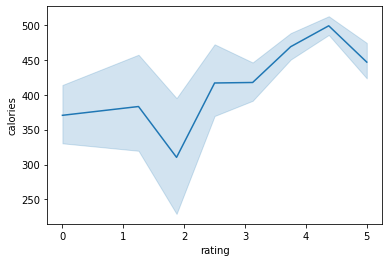

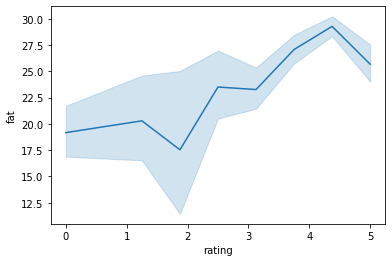

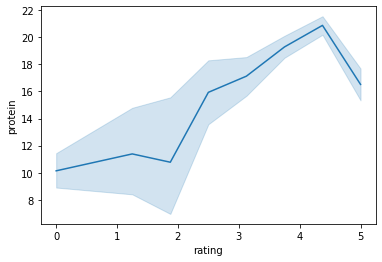

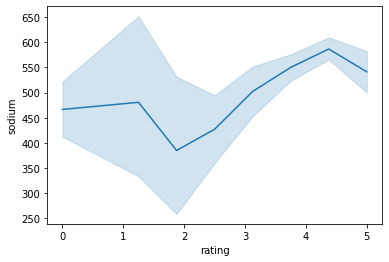

In [11]:
compare_cols = ['calories', 'fat', 'protein', 'sodium']
for col in compare_cols:
    sns.lineplot(data=data, x="rating", y=col)
    plt.show()

### Insight
As comidas com nota mais altas costumam ter mais sodio, proteina, gordura e calorias.

Contudo as comidas que receberam a nota 5(a mais alta) costumam ser mais saudaveis que as outras comidas com notas altas(4 - 4.5).

## Analisando variaveis x tempo

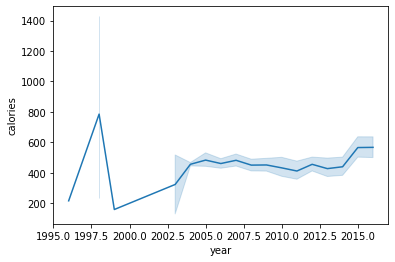

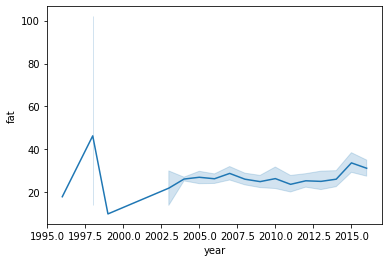

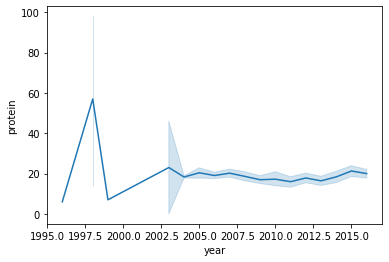

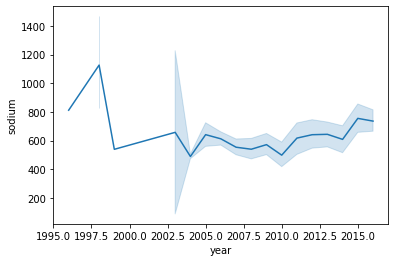

In [12]:
compare_cols = ['calories', 'fat', 'protein', 'sodium']
data_by_year = data.copy()
data_by_year['year'] = data['date'].dt.year
for col in compare_cols:
    sns.lineplot(data=data_by_year, x="year", y=col)
    plt.show()

### Insight
A quantidade de sodio, gordura e calorias aumentaram ligeiramente desde 2000, contudo  a quantidade de proteinas permaneceu estavel.

## Categorias

## Compexidade
Analisar complexidade da receita. A complexidade da receita vai ser estimada pela quantidade de ingredientes e passos

In [13]:
data['complexity'] = [len(d) * len(i) for d, i in zip(data['directions'], data['ingredients'])]
data.head(4)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,complexity
0,[Blanch onions in a saucepan of boiling water ...,18.0,1996-09-01 20:47:00+00:00,"[Bon Appétit, Salad, Mushroom, Watercress, Fet...",216.0,"The technique for cooking vegetables in water,...",6.0,0.000,Portobello Mushroom Salad à la Grecque,"[12 pearl onions, 6 tablespoons olive oil, 2 t...",812.0,45
1,[1. Soak the mushrooms in enough hot water to ...,5.0,1998-09-17 19:09:30+00:00,"[Soup/Stew, Mushroom, Vegetarian, Sukkot, Rosh...",234.0,When I first heard about Ari Weinzweig's delic...,14.0,4.375,Zingerman's Ann Arbor Mushroom and Barley Soup,"[2 tablespoons dried porcini mushrooms, 2 tabl...",1468.0,96
2,"[Preheat an oven to 350ºF., Cut the lemon into...",102.0,1998-09-22 13:11:01+00:00,"[Chicken, Ginger, Rice, Appetizer, Roast, Saut...",1428.0,"(Pollo Arrosto All'Arancia, Limone, e Zenzero)",98.0,3.750,"Roast Chicken with Orange, Lemon, and Ginger","[1 lemon, 1 roasting chicken, about 5 pounds, ...",1089.0,55
3,[Warm 2 tablespoons of the olive oil in a saut...,32.0,1998-09-22 13:11:02+00:00,"[Braise, Stew, Rosh Hashanah/Yom Kippur, Dinne...",694.0,(Stufadin di Zuca Zala),59.0,4.375,Braised Meat with Butternut Squash,"[4 tablespoons olive oil, 2 large onions, chop...",824.0,30


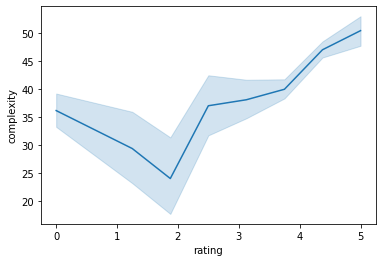

In [14]:
sns.lineplot(data=data, x="rating", y="complexity")

### Insight
Normalmente as receitas com notas mais altas são as mais complexas.

## Correlações

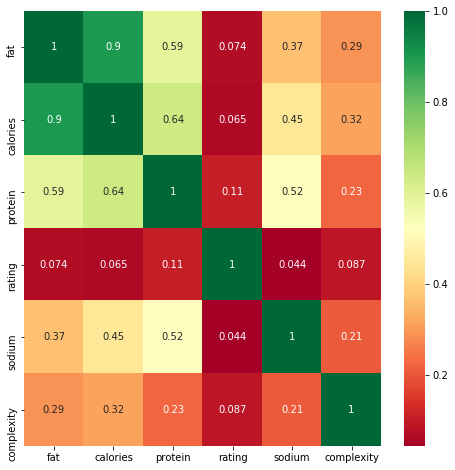

In [15]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Insight
As colunas com mais correlação com `rating` são em ordem `protein`, `complexity`, `fat`, `calories` e `sodium`. 

Contudo nenhuma das colunas possui uma correlação significativa com a coluna `rating`.

## Features mais importantes

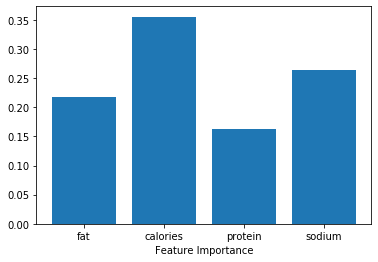

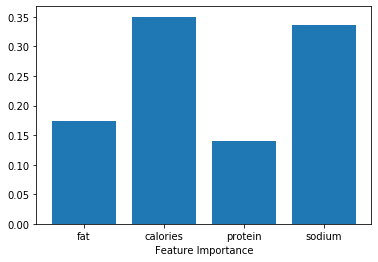

In [16]:
X = normalized_data.drop(['directions', 'date', 'categories', 'desc', 'title', 'ingredients', 'rating'], axis = 1)
Y = normalized_data['rating']

gb = GradientBoostingRegressor(n_estimators=200)
gb.fit(X, Y)

plt.bar(X.columns, gb.feature_importances_)
plt.xlabel("Feature Importance")
plt.show()

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X, Y)

plt.bar(X.columns, rf.feature_importances_)
plt.xlabel("Feature Importance")
plt.show()

### Insight
As features mais importantes para a previsão do `rating` foram `calories` e `sodium`.

Também seria possivel usar outros modelos para analisar o impacto das features. Outra técnica de calcular a importancia das features seria "Permutation Feature Importance".

Esses métodos não foram utilizados por que acredito que as técnicas escolhidas já resolvem o problema.